In [ ]:
# Load library imports
import os
import sys
import torch
import random
import logging
import regionmask
import numpy as np
import xarray as xr
import pandas as pd
from pyproj import Geod
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from pyproj import Transformer
from shapely.geometry import box
from datetime import datetime, timedelta

# Load project Imports
from src.utils.config_loader import load_project_config
from src.graph_building.graph_construction import build_mesh, \
    define_catchment_polygon
from src.data_ingestion.spatial_transformations import find_catchment_boundary
from src.data_ingestion.timeseries_data_ingestion import find_haduk_file_names, \
    load_era5_land_data, load_rainfall_data, build_rainfall_lags

In [33]:
# Set up logger config
logging.basicConfig(
    level=logging.INFO,
   format='%(levelname)s - %(message)s',
#    format='%(asctime)s - %(levelname)s - %(name)s - %(message)s',
    handlers=[logging.StreamHandler(sys.stdout)]
)

# Set up logger for file and load config file for paths and params
logger = logging.getLogger(__name__)
config = load_project_config(config_path="config/project_config.yaml")
notebook = True

# Set up seeding to define global states
random_seed = config["global"]["pipeline_settings"]["random_seed"]
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Define notebook demo catchment
catchments_to_process = config["global"]["pipeline_settings"]["catchments_to_process"]
catchment = catchments_to_process[0]
run_defra_API_calls = config["global"]["pipeline_settings"]["run_defra_api"]  # True to run API calls

logger.info(f"Show Notebook Outputs: {notebook}")
logger.info(f"Notebook Demo Catchment: {catchment.capitalize()}")

INFO - Loading configuration from: /Users/charlotte/Desktop/Dissertation_Code/config/project_config.yaml
INFO - Show Notebook Outputs: True
INFO - Notebook Demo Catchment: Eden


### Build mesh ###

To align ingested data with

In [5]:
# Select Catchment area from country wide gdf
define_catchment_polygon(
    england_catchment_gdf_path=config[catchment]['paths']['gis_catchment_boundary'],
    target_mncat=config[catchment]['target_mncat'],
    catchment=catchment,
    polygon_output_path=config[catchment]['paths']['gis_catchment_dir']
)

INFO - Eden and Esk boundary polygon(s) extracted from England data.
data/01_raw/eden/gis/eden_catchment_boundary/eden_combined_boundary.geojson
INFO - Combined Eden and Esk boundary saved to: data/01_raw/eden/gis/eden_catchment_boundary/eden_combined_boundary.geojson


In [6]:
# NB: mesh_nodes_gdf are the centroid coords, mesh_cells_gdf_polygons are polygons for e.g. averaging area
mesh_nodes_table, mesh_nodes_gdf, mesh_cells_gdf_polygons, catchment_polygon = build_mesh(
    shape_filepath=config[catchment]['paths']['gis_catchment_dir'],
    output_path=config[catchment]['paths']['mesh_nodes_output'],
    catchment=catchment,
    grid_resolution=config[catchment]['preprocessing']['graph_construction']['grid_resolution']
)

INFO - BUILD_MESH: Starting mesh construction with input: data/01_raw/eden/gis/eden_catchment_boundary/eden_combined_boundary.geojson and resolution: 1000m

INFO - Finding eden catchment spatial boundaries...

INFO - Loading  boundary from: data/01_raw/eden/gis/eden_catchment_boundary/eden_combined_boundary.geojson
INFO - Single polygon found in the catchment boundary.
INFO - Catchment bounding box: min_x=325093.81960000005, min_y=495490.0, max_x=389010.0, max_y=590440.0

INFO - Aligned minx: 325000.0, miny: 495000.0, maxx: 390000.0, maxy: 591000.0
INFO - Number of x-coordinates (bottom-left): 66
INFO - Number of y-coordinates (bottom-left): 97

INFO - Generated 6402 grid cells (centroids and polygons) within bounding box (before filtering).
INFO - Filtered down to catchment boundary containing 2750 nodes

INFO - First few mesh nodes (centroids with coordinates):

     node_id   easting  northing       lon        lat
64         0  325500.0  559500.0 -3.163979  54.924606
130        1  3

### Rainfall Ingestion and Preprocessing ###

Continue with the following once https://www.ceda.ac.uk/status/ allows.

In [ ]:
# haduk_urls = find_haduk_file_names(
#     start_date=config["global"]["data_ingestion"]["model_start_date"],
#     end_date=config["global"]["data_ingestion"]["model_end_date"],
#     base_url = config["global"]["paths"]["HAD_UK_rainfall_url"]
# )

# os.environ["NETRC"] = os.path.abspath("ceda_credentials.netrc")
# url = haduk_urls[0]

# try:
#     ds = xr.open_dataset(url, engine="netcdf4")
#     print(ds)
# except OSError as e:
#     print("Failed to open dataset. This may be due to CEDA login issues. Check https://www.ceda.ac.uk/status/")
#     print(e)

### Local Rainfall Data Ingestion and Processing (non API) ###

INFO - Finding eden catchment spatial boundaries...

INFO - Loading  boundary from: data/01_raw/eden/gis/eden_catchment_boundary/eden_combined_boundary.geojson
INFO - Single polygon found in the catchment boundary.
INFO - Catchment bounding box: min_x=325093.81960000005, min_y=495490.0, max_x=389010.0, max_y=590440.0

INFO - Converting 'easting'/'northing' to 'lon'/'lat'...
INFO - Catchment BBox (lat/lon): (np.float64(55.20808470523775), np.float64(54.34942479634069), np.float64(-2.1742353207346743), np.float64(-3.153909164951907))
INFO - Catchment polygon CRS: EPSG:27700
INFO - Catchment polygon area (approx.): 8231.092448085472 km^2
INFO - Processing rainfall data for month 01 year 2014...
INFO - Generating regionmask for first file...
INFO -     Masking rainfall data to eden catchment.
INFO -     Total NaN values in 'rainfall': 105276
INFO -     Appending rainfall data to rainfall_data_all list.

INFO - Processing rainfall data for month 02 year 2014...
INFO -     Masking rainfall d

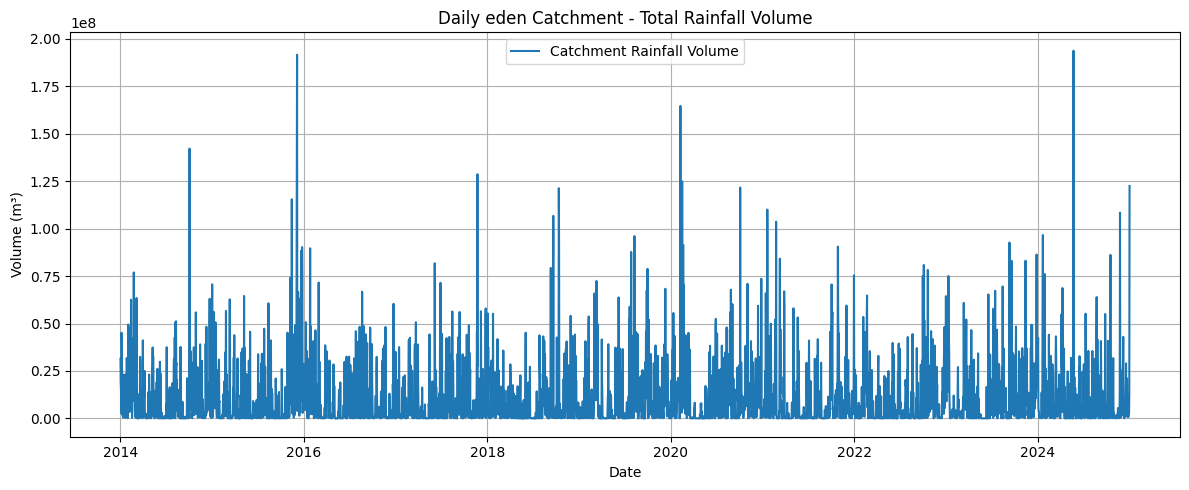

In [ ]:
# No explicit return, csv saved to csv_path for future access
load_rainfall_data(
    rainfall_dir=config[catchment]["paths"]["rainfall_filename_dir"],
    shape_filepath=config[catchment]["paths"]["gis_catchment_dir"],
    processed_output_dir=config[catchment]["paths"]["rainfall_processed_output_dir"],
    fig_path=config[catchment]["paths"]["rainfall_fig_path"],
    required_crs=27700,
    catchment=catchment
)

In [ ]:
# No explicit return, csv saved to csv_path for future access
load_era5_land_data(
    catchment=catchment,
    shape_filepath=config[catchment]['paths']['gis_catchment_dir'],
    required_crs=27700,
    cdsapi_path=config["global"]["paths"]["CDSAPI_path"],
    start_date=config["global"]["data_ingestion"]["model_start_date"],
    end_date=config["global"]["data_ingestion"]["model_end_date"],
    run_era5_land_api=config["global"]["pipeline_settings"]["run_era5_land_api"],
    raw_output_dir=config[catchment]["paths"]["aet_raw_output_dir"],
    processed_output_dir=config[catchment]["paths"]["aet_processed_output_dir"],
    csv_path=config[catchment]["paths"]["aet_csv_path"],
    fig_path=config[catchment]["paths"]["aet_fig_path"],
    era5_feat='e',
    era5_long='total_evaporation',
    feat_name='aet',
    aggregation_type='sum'
)

In [ ]:
build_rainfall_lags()

### Temperature Ingestion and Preprocessing ###

Continue with the following once https://www.ceda.ac.uk/status/ allows.

### Surface Pressure Ingestion and Preprocessing ###

In [ ]:
# No explicit return, csv saved to csv_path for future access
load_era5_land_data(
    catchment=catchment,
    shape_filepath=config[catchment]['paths']['gis_catchment_dir'],
    required_crs=27700,
    cdsapi_path=config["global"]["paths"]["CDSAPI_path"],
    start_date=config["global"]["data_ingestion"]["model_start_date"],
    end_date=config["global"]["data_ingestion"]["model_end_date"],
    run_era5_land_api=config["global"]["pipeline_settings"]["run_era5_land_api"],
    raw_output_dir=config[catchment]["paths"]["sp_raw_output_dir"],
    processed_output_dir=config[catchment]["paths"]["sp_processed_output_dir"],
    csv_path=config[catchment]["paths"]["sp_csv_path"],
    fig_path=config[catchment]["paths"]["sp_fig_path"],
    era5_feat='sp',
    era5_long='surface_pressure',
    feat_name='surface_pressure',
    aggregation_type='mean'
)

### AET Ingestion and Preprocessing ###

In [ ]:
# No explicit return, csv saved to csv_path for future access
load_era5_land_data(
    catchment=catchment,
    shape_filepath=config[catchment]['paths']['gis_catchment_dir'],
    required_crs=27700,
    cdsapi_path=config["global"]["paths"]["CDSAPI_path"],
    start_date=config["global"]["data_ingestion"]["model_start_date"],
    end_date=config["global"]["data_ingestion"]["model_end_date"],
    run_era5_land_api=config["global"]["pipeline_settings"]["run_era5_land_api"],
    raw_output_dir=config[catchment]["paths"]["aet_raw_output_dir"],
    processed_output_dir=config[catchment]["paths"]["aet_processed_output_dir"],
    csv_path=config[catchment]["paths"]["aet_csv_path"],
    fig_path=config[catchment]["paths"]["aet_fig_path"],
    era5_feat='e',
    era5_long='total_evaporation',
    feat_name='aet',
    aggregation_type='sum'
)

### 2m Surface Temperature Ingestion and Preprocessing ###

In [ ]:
# No explicit return, csv saved to csv_path for future access
load_era5_land_data(
    catchment=catchment,
    shape_filepath=config[catchment]['paths']['gis_catchment_dir'],
    required_crs=27700,
    cdsapi_path=config["global"]["paths"]["CDSAPI_path"],
    start_date=config["global"]["data_ingestion"]["model_start_date"],
    end_date=config["global"]["data_ingestion"]["model_end_date"],
    run_era5_land_api=config["global"]["pipeline_settings"]["run_era5_land_api"],
    raw_output_dir=config[catchment]["paths"]["2t_raw_output_dir"],
    processed_output_dir=config[catchment]["paths"]["2t_processed_output_dir"],
    csv_path=config[catchment]["paths"]["2t_csv_path"],
    fig_path=config[catchment]["paths"]["2t_fig_path"],
    era5_feat='2t',
    era5_long='2m_temperature',
    feat_name='2m_temp',
    aggregation_type='mean'
)